In [ ]:
# ‚úÖ Colab ÌôòÍ≤Ω Í≥†Ï†ï ÏÑ∏ÌåÖ (Ìï≠ÏÉÅ Îß® ÏúÑÏóê Ïã§Ìñâ!)
!pip install -q numpy==1.26.4
!pip install -q scikit-surprise==1.1.3
!pip install -q optuna==3.6.1

import numpy as np, pandas as pd, optuna
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
print("‚úÖ ÌôòÍ≤Ω ÏÑ∏ÌåÖ ÏôÑÎ£å (numpy 1.26.4 / scikit-surprise 1.1.3 / optuna 3.6.1)")


‚úÖ ÌôòÍ≤Ω ÏÑ∏ÌåÖ ÏôÑÎ£å (numpy 1.26.4 / scikit-surprise 1.1.3 / optuna 3.6.1)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)  # Î™®Îì† Ïª¨Îüº ÌëúÏãú
pd.set_option("display.width", 2000)        # Ìïú Ï§ÑÏóê ÌëúÏãúÌï† Ìè≠ ÎäòÎ¶¨Í∏∞
pd.set_option("display.max_colwidth", None) # Î¨∏ÏûêÏó¥ ÏûòÎ¶º Î∞©ÏßÄ

# **ÌïúÍ∏Ä**

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] =False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# **Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞ Î∞è Ï†ÑÏ≤òÎ¶¨**

In [ ]:
from google.colab import drive
import pandas as pd


# 1. Íµ¨Í∏Ä ÎìúÎùºÏù¥Î∏å ÎßàÏö¥Ìä∏
drive.mount('/content/drive')

# 2. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
base_path = "/content/drive/MyDrive"

links = pd.read_csv(f"{base_path}/links.csv")
movies = pd.read_csv(f"{base_path}/movies.csv")
ratings = pd.read_csv(f"{base_path}/ratings.csv")
tags = pd.read_csv(f"{base_path}/tags.csv")



# ÌôïÏù∏
#print(links.shape, movies.shape, ratings.shape, tags.shape)
#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# timestamp ‚Üí datetime Î≥ÄÌôò
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# 2020ÎÖÑ Ïù¥ÌõÑ Îç∞Ïù¥ÌÑ∞Îßå ÏÇ¨Ïö©
cutoff_date = pd.Timestamp('2020-01-01')
ratings = ratings[ratings['timestamp'] >= cutoff_date].copy()
tags = tags[tags['timestamp'] >= cutoff_date].copy()

# ratingsÏóê Ï°¥Ïû¨ÌïòÎäî ÏòÅÌôîÎßå ÌïÑÌÑ∞ÎßÅ
movie_ids = ratings['movieId'].unique()
movies = movies[movies['movieId'].isin(movie_ids)].copy()
links = links[links['movieId'].isin(movie_ids)].copy()

# ÎßàÏßÄÎßâ ÎÇ†Ïßú ÌôïÏù∏
last_rating_date = ratings['timestamp'].max()
last_tag_date = tags['timestamp'].max()

# ÌôïÏù∏ Ï∂úÎ†•
print("ratings shape:", ratings.shape)
#print("tags shape:", tags.shape)
#print("movies shape:", movies.shape)
#print("links shape:", links.shape)
#print("ratings ÎßàÏßÄÎßâ ÎÇ†Ïßú:", last_rating_date)
#print("tags ÎßàÏßÄÎßâ ÎÇ†Ïßú:", last_tag_date)


ratings shape: (4635230, 4)


# **Ïù∏Í∏∞/Ïà®Í≤®ÏßÑ Î≥¥ÏÑù Í∞ÄÏ§ëÏπò ÏÑ§Ï†ï**

In [ ]:
# Ïù∏Í∏∞ / Ïà®Í≤®ÏßÑ Î≥¥ÏÑù

# ÏÉÅÏúÑ 1% Í∏∞Ï§Ä
popular_threshold = ratings.groupby("movieId")["rating"].count().quantile(0.99)

movie_stats = ratings.groupby("movieId").agg(
    count=("rating", "count"),
    mean_rating=("rating", "mean")
).reset_index()

# Ïù∏Í∏∞(Top 1%) ÌèâÍ∑† ÌèâÏ†ê
popular_avg = movie_stats.loc[movie_stats["count"] >= popular_threshold, "mean_rating"].mean()

# Ïù∏Í∏∞ ÏòÅÌôî: ÌèâÏ†ê Ïàò ÏÉÅÏúÑ 1%
movie_stats["is_popular"] = movie_stats["count"] >= popular_threshold

# Ïà®Í≤®ÏßÑ Î≥¥ÏÑù: ÌèâÏ†ê Ïàò ÏÉÅÏúÑ 10%~1% Íµ¨Í∞Ñ & Ïù∏Í∏∞ ÌèâÍ∑† ÌèâÏ†êÎ≥¥Îã§ ÎÜíÏùå
movie_stats["is_hidden_gem"] = (
    (movie_stats["count"] >= movie_stats["count"].quantile(0.90)) &
    (movie_stats["count"] < popular_threshold) &
    (movie_stats["mean_rating"] > popular_avg)
)

# Í∞ÄÏ§ëÏπò ‚Üí ÌäúÎãù ÎåÄÏÉÅ (Í∞í ÏóÜÏùå, OptunaÏóêÏÑú Ìï†Îãπ)
POPULAR_WEIGHT = None
HIDDEN_GEM_WEIGHT = None


# **Ïû•Î•¥Î≥Ñ Î∂ÑÏÇ∞ Í∞ÄÏ§ëÏπò ÏÑ§Ï†ï**

In [ ]:
# Ïû•Î•¥Î≥Ñ Î∂ÑÏÇ∞

movies['genres_list'] = movies['genres'].str.split('|')
ratings_exploded = ratings.merge(movies[['movieId','genres_list']], on='movieId', how='left').explode('genres_list')

genre_variance = ratings_exploded.groupby("genres_list")["rating"].var().to_dict()

# Í∞ÄÏ§ëÏπò ‚Üí ÌäúÎãù ÎåÄÏÉÅ
GENRE_VAR_WEIGHT = None


# **Î©ÄÌã∞ Ïû•Î•¥ Í∞ÄÏ§ëÏπò ÏÑ§Ï†ï**

In [ ]:
# Î©ÄÌã∞/Îã®Ïùº Ïû•Î•¥

movies["is_multi_genre"] = movies["genres_list"].apply(lambda x: len(x) > 1)

# Í∞ÄÏ§ëÏπò ‚Üí ÌäúÎãù ÎåÄÏÉÅ
MULTI_GENRE_WEIGHT = None
SINGLE_GENRE_WEIGHT = None


# **Optuna SVD**

In [ ]:
# ÎùºÏù¥Î∏åÎü¨Î¶¨
import numpy as np
import pandas as pd
import optuna
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Surprise Îç∞Ïù¥ÌÑ∞ÏÖã & SVD ÌïôÏäµ (ratings ÏÇ¨Ïö©!)
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd_model = SVD(n_factors=100, n_epochs=30, random_state=42)
svd_model.fit(trainset)

# ÏïÑÏù¥ÌÖú ÏûÑÎ≤†Îî©(Q)
item_factors = np.array([svd_model.qi[i] for i in range(len(trainset.all_items()))])
item_index_to_id = {i: int(trainset.to_raw_iid(i)) for i in range(len(trainset.all_items()))}
item_id_to_index = {v: k for k, v in item_index_to_id.items()}

# ÏÇ¨Ïö©Ïûê ÌûàÏä§ÌÜ†Î¶¨/Ï†ÑÏó≠ ÌèâÍ∑† (ratings ÏÇ¨Ïö©!)
global_mean = ratings['rating'].mean()

# trainset Í∏∞Î∞ò user_hist ÏÉùÏÑ± (Îç∞Ïù¥ÌÑ∞ ÎàÑÏàò Î∞©ÏßÄ)
user_hist_train = {}

for uid_inner, iid_inner, r in trainset.all_ratings():
    # Surprise ÎÇ¥Î∂Ä ID ‚Üí ÏõêÎûò IDÎ°ú Î≥ÄÌôò
    uid = int(trainset.to_raw_uid(uid_inner))
    iid = int(trainset.to_raw_iid(iid_inner))

    if uid not in user_hist_train:
        user_hist_train[uid] = []
    user_hist_train[uid].append((iid, r))


# Ïû•Î•¥ Î∂ÑÏÇ∞ Î≥¥Ï°∞ Ìï®Ïàò (Ïû•Î•¥ Î∂ÑÏÇ∞ Í≥ÑÏÇ∞ÏùÄ ratings_exploded Í∏∞Î∞ò Ïú†ÏßÄ)
def _adj_vf(mid):
    genres = movies.loc[movies["movieId"]==mid, "genres_list"].values
    if len(genres) and isinstance(genres[0], list) and len(genres[0]) > 0:
        vals = []
        for g in genres[0]:
            v = genre_variance.get(g, 1.0)
            if not np.isfinite(v):
                v = 1.0
            vals.append(1.0 / (1.0 + v))
        return float(np.mean(vals))
    return 0.0

# ÌèâÏ†êÏö© Î≥¥Ï†ï(ÌïôÏäµ/ÌèâÍ∞ÄÏö©)
def _adjust_rating_score(score, mid, pop_w, gem_w, genre_w, multi_w, single_w):
    s = float(score)
    if movie_stats.loc[movie_stats["movieId"]==mid, "is_popular"].any():
        s += pop_w
    if movie_stats.loc[movie_stats["movieId"]==mid, "is_hidden_gem"].any():
        s += gem_w
    s += genre_w * _adj_vf(mid)
    is_multi = movies.loc[movies["movieId"]==mid, "is_multi_genre"].values
    if len(is_multi):
        s += (multi_w if bool(is_multi[0]) else single_w)
    return float(np.clip(s, 0.5, 5.0))

# Ïú†ÏÇ¨ÎèÑÏö© Î≥¥Ï†ï(Ï∂îÏ≤ú Îû≠ÌÇπÏö©)
def _adjust_sim_score(sim, mid, pop_w, gem_w, genre_w, multi_w, single_w):
    base = max(0.0, float(sim))  # ÏùåÏàò Ïú†ÏÇ¨ÎèÑ Ïª∑
    bonus = 0.0
    if movie_stats.loc[movie_stats["movieId"]==mid, "is_popular"].any():
        bonus += pop_w
    if movie_stats.loc[movie_stats["movieId"]==mid, "is_hidden_gem"].any():
        bonus += gem_w
    bonus += genre_w * _adj_vf(mid)
    is_multi = movies.loc[movies["movieId"]==mid, "is_multi_genre"].values
    if len(is_multi):
        bonus += (multi_w if bool(is_multi[0]) else single_w)
    return base + bonus

# ÏïÑÏù¥ÌÖú Í∏∞Î∞ò ÏòàÏ∏°Ïπò(ÏÇ¨Ïö©Ïûê ÌûàÏä§ÌÜ†Î¶¨ Í∏∞Î∞ò k-NN Í∞ÄÏ§ë ÌèâÍ∑†)
def _predict_by_item_knn(uid, iid, top_m=30):
    hist = user_hist_train.get(uid, [])
    if not hist or iid not in item_id_to_index:
        return global_mean
    tgt_idx = item_id_to_index[iid]
    tgt_vec = item_factors[tgt_idx].reshape(1, -1)

    cand = [(mid, r) for (mid, r) in hist if (mid != iid and mid in item_id_to_index)]
    if not cand:
        return global_mean
    cand_indices = np.array([item_id_to_index[mid] for (mid, _) in cand])
    cand_ratings = np.array([r for (_, r) in cand], dtype=float)

    sims = cosine_similarity(tgt_vec, item_factors[cand_indices])[0]
    if len(sims) > top_m:
        top_idx = np.argpartition(-sims, top_m-1)[:top_m]
        sims = sims[top_idx]; cand_ratings = cand_ratings[top_idx]

    denom = np.sum(np.abs(sims)) + 1e-8
    return float(np.sum(sims * cand_ratings) / denom)

# Optuna: Í∞ÄÏ§ëÏπò ÏµúÏ†ÅÌôî (RMSE ÏµúÏÜåÌôî) ‚Äî 5Í∞ú Í∞ÄÏ§ëÏπò Î≤îÏúÑÎäî 0~0.5
def objective(trial):
    pop_w   = trial.suggest_float('POPULAR_WEIGHT', 0.0, 0.5)
    gem_w   = trial.suggest_float('HIDDEN_GEM_WEIGHT', 0.0, 0.5)
    genre_w = trial.suggest_float('GENRE_VAR_WEIGHT', 0.0, 0.5)
    multi_w = trial.suggest_float('MULTI_GENRE_WEIGHT', 0.0, 0.5)
    single_w= trial.suggest_float('SINGLE_GENRE_WEIGHT', 0.0, 0.5)

    EVAL_SAMPLE = min(3000, len(testset))
    sq_err = []
    for (uid, iid, true_r) in testset[:EVAL_SAMPLE]:
        base = _predict_by_item_knn(uid, iid, top_m=30)
        adj = _adjust_rating_score(base, iid, pop_w, gem_w, genre_w, multi_w, single_w)
        sq_err.append((true_r - adj) ** 2)

    return float(np.sqrt(np.mean(sq_err))) if sq_err else 1e9

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20, show_progress_bar=False)
best_params = study.best_params
print("Best params:", best_params)
print("Best RMSE:", study.best_value)

# Ï∂îÏ≤ú: Î≥¥Ï†ï ÌõÑ Ïû¨Ï†ïÎ†¨ + ÌõÑÎ≥¥ ÌíÄ(pool) Ï†ÅÏö© + ÌÜµÍ≥Ñ Ïª¨Îüº Ìè¨Ìï® Î∞òÌôò
# Ï∂îÍ∞Ä Ï°∞Í±¥: Ï∂îÏ≤ú ÎåÄÏÉÅÏùÄ ÌèâÏ†ê Í∞úÏàò ÏÉÅÏúÑ 10% Ïù¥ÏÉÅÎßå ÌóàÏö©
rec_count_threshold = movie_stats['count'].quantile(0.90)
count_lookup = movie_stats.set_index('movieId')['count'].to_dict()

def recommend_similar_movies(movie_ids, top_n=10, params=None, pool_size=500):
    if not isinstance(movie_ids, (list, tuple, set)):
        movie_ids = [int(movie_ids)]
    else:
        movie_ids = [int(mid) for mid in movie_ids]

    valid_ids = [mid for mid in movie_ids if mid in item_id_to_index]
    if not valid_ids:
        return pd.DataFrame(columns=['movieId','title','score','sim','mean_rating','count'])

    base_vecs = [item_factors[item_id_to_index[mid]] for mid in valid_ids]
    base_vec = np.mean(base_vecs, axis=0).reshape(1, -1)
    sims = cosine_similarity(base_vec, item_factors)[0]

    exclude = {item_id_to_index[mid] for mid in valid_ids}
    order = np.argsort(-sims)

    cand_idx = []
    for idx in order:
        if idx in exclude:
            continue
        cand_idx.append(idx)
        if len(cand_idx) >= pool_size:
            break

    rows = []
    for idx in cand_idx:
        mid = item_index_to_id[idx]
        if count_lookup.get(mid, 0) < rec_count_threshold:
            continue

        base = float(sims[idx])   # ‚úÖ Î≥¥Ï†ï Ï†Ñ Ïú†ÏÇ¨ÎèÑ
        score = base if not params else _adjust_sim_score(
            base, mid,
            params['POPULAR_WEIGHT'],
            params['HIDDEN_GEM_WEIGHT'],
            params['GENRE_VAR_WEIGHT'],
            params['MULTI_GENRE_WEIGHT'],
            params['SINGLE_GENRE_WEIGHT'],
        )
        rows.append((mid, score, base))

    if not rows:
        return pd.DataFrame(columns=['movieId','title','score','sim','mean_rating','count'])

    df = pd.DataFrame(rows, columns=['movieId','score','sim'])
    df = df.sort_values(['score','sim'], ascending=[False, False]).head(top_n)

    out = (
        df[['movieId','score','sim']]
        .merge(movies[['movieId','title']], on='movieId', how='left')
        .merge(movie_stats[['movieId','mean_rating','count']], on='movieId', how='left')
    )
    out['score'] = out['score'].astype(float).round(4)
    out['sim'] = out['sim'].astype(float).round(4)
    out['mean_rating'] = out['mean_rating'].astype(float).round(3)
    return out[['movieId','title','score','sim','mean_rating','count']]



[I 2025-09-29 05:59:56,387] A new study created in memory with name: no-name-ccd4eb96-c0e0-45c4-aada-59014328b7b3
[I 2025-09-29 06:00:10,351] Trial 0 finished with value: 1.0185548854452577 and parameters: {'POPULAR_WEIGHT': 0.18727005942368125, 'HIDDEN_GEM_WEIGHT': 0.4753571532049581, 'GENRE_VAR_WEIGHT': 0.36599697090570255, 'MULTI_GENRE_WEIGHT': 0.2993292420985183, 'SINGLE_GENRE_WEIGHT': 0.07800932022121826}. Best is trial 0 with value: 1.0185548854452577.
[I 2025-09-29 06:00:24,102] Trial 1 finished with value: 1.0102799052370282 and parameters: {'POPULAR_WEIGHT': 0.07799726016810132, 'HIDDEN_GEM_WEIGHT': 0.02904180608409973, 'GENRE_VAR_WEIGHT': 0.4330880728874676, 'MULTI_GENRE_WEIGHT': 0.3005575058716044, 'SINGLE_GENRE_WEIGHT': 0.35403628889802274}. Best is trial 1 with value: 1.0102799052370282.
[I 2025-09-29 06:00:37,727] Trial 2 finished with value: 0.9290415749974709 and parameters: {'POPULAR_WEIGHT': 0.010292247147901223, 'HIDDEN_GEM_WEIGHT': 0.48495492608099716, 'GENRE_VAR_WE

Best params: {'POPULAR_WEIGHT': 0.13974606901214937, 'HIDDEN_GEM_WEIGHT': 0.2816835124406072, 'GENRE_VAR_WEIGHT': 0.10325028984445817, 'MULTI_GENRE_WEIGHT': 0.06391216214132, 'SINGLE_GENRE_WEIGHT': 0.25360722514011735}
Best RMSE: 0.8913237544873592


# **test Ï∂úÎ†•**

In [ ]:
sample_movie = int(movies['movieId'].sample(1, random_state=42).iloc[0])
base_title = movies.loc[movies['movieId']==sample_movie, 'title'].values[0]
base_stats = movie_stats.loc[movie_stats['movieId']==sample_movie, ['mean_rating','count']].iloc[0]
print(f"Í∏∞Ï§Ä ÏòÅÌôî: {base_title} (movieId={sample_movie})")
print(f"- Í∏∞Ï§Ä ÏòÅÌôî ÌèâÍ∑† ÌèâÏ†ê: {base_stats['mean_rating']:.3f}, ÌèâÏ†ê Í∞úÏàò: {int(base_stats['count'])}")

recs = recommend_similar_movies(sample_movie, top_n=10, params=best_params)
print(recs)


Í∏∞Ï§Ä ÏòÅÌôî: Here Awhile (2019) (movieId=218739)
- Í∏∞Ï§Ä ÏòÅÌôî ÌèâÍ∑† ÌèâÏ†ê: 3.667, ÌèâÏ†ê Í∞úÏàò: 3
   movieId                                           title   score     sim  mean_rating  count
0   129514          George Carlin: It's Bad for Ya! (2008)  0.8511  0.2680        3.928    138
1   130970      George Carlin: Life Is Worth Losing (2005)  0.8464  0.2633        3.973    111
2     8528         Dodgeball: A True Underdog Story (2004)  0.6971  0.2559        3.383   2098
3    93838                     The Raid: Redemption (2011)  0.6763  0.2804        3.853   1104
4     3175                             Galaxy Quest (1999)  0.6351  0.2415        3.766   1410
5    54785                                Halloween (2007)  0.6067  0.3060        2.960    238
6     3869  Naked Gun 2 1/2: The Smell of Fear, The (1991)  0.6060  0.3046        3.632    509
7     2296                  Night at the Roxbury, A (1998)  0.5994  0.2980        2.905    221
8     1760                             

In [ ]:
# Inception (2010)Ïùò movieId ÏßÅÏ†ë ÏßÄÏ†ï
sample_movie = 79132

# Í∏∞Ï§Ä ÏòÅÌôî Ï†ïÎ≥¥
base_title = movies.loc[movies['movieId']==sample_movie, 'title'].values[0]
base_stats = movie_stats.loc[movie_stats['movieId']==sample_movie, ['mean_rating','count']]

print(f"üé¨ Í∏∞Ï§Ä ÏòÅÌôî: {base_title} (movieId={sample_movie})")
if not base_stats.empty:
    print(f"- ÌèâÍ∑† ÌèâÏ†ê: {base_stats['mean_rating'].values[0]:.3f}, "
          f"ÌèâÏ†ê Í∞úÏàò: {int(base_stats['count'].values[0])}")

# Ï∂îÏ≤ú Í≤∞Í≥º
recs = recommend_similar_movies(sample_movie, top_n=10, params=best_params)
print(recs.to_string(index=False))


üé¨ Í∏∞Ï§Ä ÏòÅÌôî: Inception (2010) (movieId=79132)
- ÌèâÍ∑† ÌèâÏ†ê: 4.163, ÌèâÏ†ê Í∞úÏàò: 15103
 movieId                         title  score    sim  mean_rating  count
  109487           Interstellar (2014) 0.9747 0.7232        4.198  12275
   74458         Shutter Island (2010) 0.8607 0.6054        4.055   8371
   48780          Prestige, The (2006) 0.8561 0.6016        4.184   7849
  287699            Oppenheimer (2023) 0.8497 0.2621        4.083   1152
  167832    The Invisible Guest (2016) 0.8287 0.2429        4.001    799
  208108            Dark Waters (2019) 0.8281 0.2406        3.901    930
   91529 Dark Knight Rises, The (2012) 0.8122 0.5595        3.940   8445
   58559       Dark Knight, The (2008) 0.7827 0.5289        4.194  13561
   33794          Batman Begins (2005) 0.7434 0.4904        3.882   8024
  164179                Arrival (2016) 0.7324 0.2910        4.066   8691


üé¨ Í∏∞Ï§Ä ÏòÅÌôî: Inception (2010)


movieId                          title   score     sim  mean_rating  count
0   109487            Interstellar (2014)  0.9747  0.7232        4.198  12275
1    74458          Shutter Island (2010)  0.8607  0.6054        4.055   8371
2    48780           Prestige, The (2006)  0.8561  0.6016        4.184   7849
3   287699             Oppenheimer (2023)  0.8497  0.2621        4.083   1152
4   167832     The Invisible Guest (2016)  0.8287  0.2429        4.001    799
5   208108             Dark Waters (2019)  0.8281  0.2406        3.901    930
6    91529  Dark Knight Rises, The (2012)  0.8122  0.5595        3.940   8445
7    58559        Dark Knight, The (2008)  0.7827  0.5289        4.194  13561
8    33794           Batman Begins (2005)  0.7434  0.4904        3.882   8024
9   164179                 Arrival (2016)  0.7324  0.2910        4.066   8691

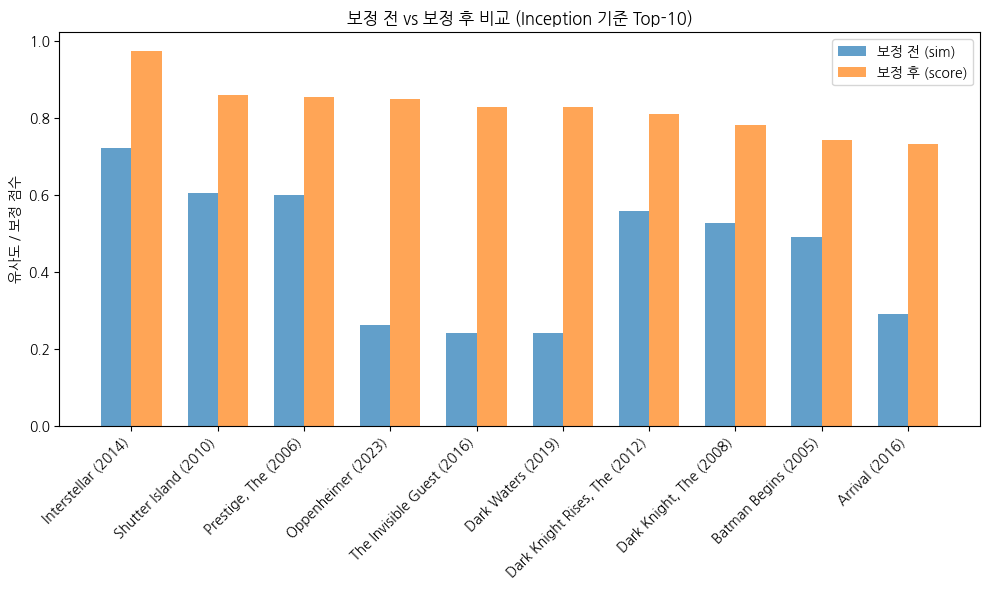

In [ ]:
# Inception movieId
sample_movie = int(movies.loc[movies['title']=="Inception (2010)", 'movieId'].iloc[0])
recs = recommend_similar_movies(sample_movie, top_n=10, params=best_params)

# Ï∂îÏ≤ú Í≤∞Í≥º (Î≥¥Ï†ï Ï†Ñ sim + Î≥¥Ï†ï ÌõÑ score Ìè¨Ìï®)
recs = recommend_similar_movies(sample_movie, top_n=10, params=best_params)

print("üé¨ Í∏∞Ï§Ä ÏòÅÌôî: Inception (2010)")
display(recs)

# Î≥¥Ï†ï Ï†Ñ vs Î≥¥Ï†ï ÌõÑ Ï†êÏàò ÎπÑÍµê
plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(recs))

plt.bar(x - bar_width/2, recs["sim"], bar_width, label="Î≥¥Ï†ï Ï†Ñ (sim)", alpha=0.7)
plt.bar(x + bar_width/2, recs["score"], bar_width, label="Î≥¥Ï†ï ÌõÑ (score)", alpha=0.7)

plt.xticks(x, recs["title"], rotation=45, ha="right")
plt.ylabel("Ïú†ÏÇ¨ÎèÑ / Î≥¥Ï†ï Ï†êÏàò")
plt.title("Î≥¥Ï†ï Ï†Ñ vs Î≥¥Ï†ï ÌõÑ ÎπÑÍµê (Inception Í∏∞Ï§Ä Top-10)")
plt.legend()
plt.tight_layout()
plt.show()


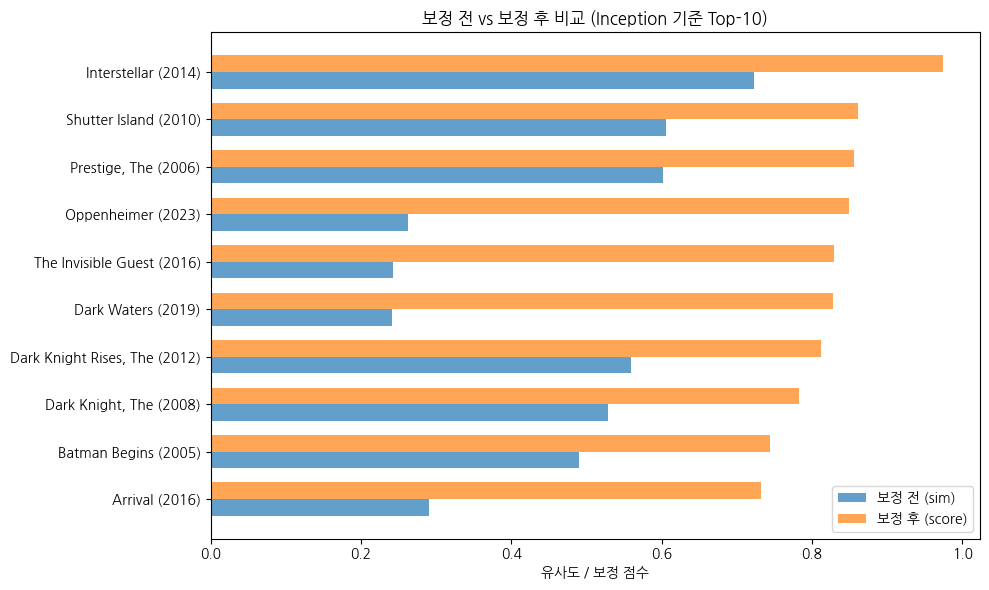

In [ ]:
# score Í∏∞Ï§Ä ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
recs_sorted = recs.sort_values("score", ascending=True).reset_index(drop=True)

# Î≥¥Ï†ï Ï†Ñ vs Î≥¥Ï†ï ÌõÑ Ï†êÏàò ÎπÑÍµê (Í∞ÄÎ°ú ÎßâÎåÄ)
plt.figure(figsize=(10,6))
bar_height = 0.35
y = np.arange(len(recs_sorted))

plt.barh(y - bar_height/2, recs_sorted["sim"], bar_height, label="Î≥¥Ï†ï Ï†Ñ (sim)", alpha=0.7)
plt.barh(y + bar_height/2, recs_sorted["score"], bar_height, label="Î≥¥Ï†ï ÌõÑ (score)", alpha=0.7)

plt.yticks(y, recs_sorted["title"])
plt.xlabel("Ïú†ÏÇ¨ÎèÑ / Î≥¥Ï†ï Ï†êÏàò")
plt.title("Î≥¥Ï†ï Ï†Ñ vs Î≥¥Ï†ï ÌõÑ ÎπÑÍµê (Inception Í∏∞Ï§Ä Top-10)")
plt.legend()
plt.tight_layout()
plt.show()
